In [1]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.spatial import KDTree
from tqdm import tqdm
import pickle 
import math 

from Utilities.operators_interp import make_tree, calc_grad, f_interp

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = False
folder = 'sedov'
snap = '100'
m = 5
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    cross_section = True
    x_chosen = 10
    y_chosen = -5
    xepsilon = 0.5
    yepsilon = 0.5
    epsilon = 0.02
elif folder == 'sedov':
    is_tde = False
    epsilon = 0.02
    cross_section = False

In [3]:
def find_Tmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    a = 2*gamma*(gamma-1)
    minusb = gamma*2 - 6*gamma + ratio*(gamma+1)**2 + 1
    msquared = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(msquared)

def find_Pmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    msquared = (ratio * (gamma+1) + gamma - 1) / (2*gamma)
    return np.sqrt(msquared)

def find_Denmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    denom = gamma + 1 - ratio * (gamma-1)
    msquared = 2 * ratio / denom
    return np.sqrt(msquared)


In [4]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, zone_tree, x_zone, y_zone, z_zone, idx, div, dir, direction):
    """ Start from one cell and walk along the shock direction till you go out the shock zone accoridng to Schaal14 (par 2.3.3).
    Parameters
    -----------
    sim_tree: tree.
        Simualation points. 
    X, Y, Z: arrays.
        Points coordinates.
    are_u_shock: bool array.
        Says if a simulation cell is in the shock zone.
    x_zone, y_zone, z_zone: arrays.
        Shock zone points coordinates.
    all_idx: array.
        Tree indeces identifying the cells in the shock zone.
    idx: int.
        Index of the chosen point between the one in the shock zone.
    div: array.
        Velocity divergence of the shock zone points.
    dir: 3D-array.
        Shock direction of the shock zone points.
    delta: float.
        Step you do from your chosen point. It has to be positive!
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns:
    -----------
    final_tree_index: int.
        Tree index of the pre/post shock cell corresponding to the starting one.
    """ 
    # Take the necessary info of your starting point 
    x_point = x_zone[idx]
    y_point = y_zone[idx]
    z_point = z_zone[idx]   
    point = np.array([x_point, y_point, z_point])
    r_point = np.linalg.norm(point)
    div_v = div[idx]
    dir_sh = np.array([dir[0][idx],dir[1][idx],dir[2][idx]])
    
    _, _, dist = k3match.cartesian(X,Y,Z, x_point, y_point, z_point, 2*r_point)
    dist = np.delete(dist, np.argmin(dist))
    delta = np.min(dist)
    
    # Walk till you go out the shock zone
    check_zone = True 
    k = 1
    while check_zone == True:
        if direction == 'pre':
            new_point = point + k * delta * dir_sh
        elif direction == 'post':
            new_point = point - k * delta * dir_sh
        _, idx  = sim_tree.query(new_point)
        check_zone = are_u_shock[idx]

        div_next = f_interp(zone_tree, div, x_zone, y_zone, z_zone, new_point)
        dir_next = calc_grad(zone_tree, dir[0], dir[1], dir[2], x_zone, y_zone, z_zone, new_point, delta)

        # if lower div v, you discard the ray.
        if div_next < div_v:
            return False, 0 # and then you don't take this cell

        # if opposite direction in shocks, you turn/stop.
        if np.dot(dir_sh, dir_next) < 0:
            check_zone = False # so you exit from the while
        
        k += 0.1 #think out to increase it 
    
    return True, new_point #idx

def shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, zone_tree, x_zone, y_zone, z_zone, div, dir):
    """ 
    Find among the cells in the shock zone the one in the shock surface 
    (output: indeces referring to the shockzonefile) 
    and its pre/post shock cells (output: tree indeces).
    """
    surface_Tmach = []
    surface_Pmach = []
    surface_Denmach = []

    #indeces referring to the shockzone file: you use them on xyz_zone and dir
    indeces = [] 
    # indeces referring to the list of ALL simulation cells: you use them on XYZ
    pre_points = []
    post_points = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        print(idx)

        in_zone, post_zone = ray_tracer(sim_tree, X, Y, Z, are_u_shock, 
                                zone_tree, x_zone, y_zone, z_zone, 
                                idx, div, dir, direction = 'post')
        if in_zone == False:
            continue
        else:
            Tpost =  f_interp(sim_tree, Temp, X, Y, Z, post_zone)
            in_zone, pre_zone = ray_tracer(sim_tree, X, Y, Z, are_u_shock, 
                                zone_tree, x_zone, y_zone, z_zone, 
                                idx, div, dir, direction = 'pre')
            if in_zone == False:
                continue
            else:
                Tpre = f_interp(sim_tree, Temp, X, Y, Z, pre_zone)

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds 
                if Tbump < 1:
                    continue 

                # We should also avoid the cells with Tbump< than the one (1.2921782544378697) inferred from M=M_min... So condition 2 doesn't work in shock zone?
                if Tbump < 1.292:
                    continue 
                
                indeces.append(idx)
                pre_points.append(pre_zone)
                post_points.append(post_zone)
                Ppre = f_interp(sim_tree, Press, X, Y, Z, pre_zone)
                Ppost = f_interp(sim_tree, Press, X, Y, Z, post_zone)
                Pbump = Ppost/Ppre
                Denpre = f_interp(sim_tree, Den, X, Y, Z, pre_zone)
                Denpost = f_interp(sim_tree, Den, X, Y, Z, post_zone)
                Denbump = Denpost/Denpre
                
                Tmach = find_Tmach(Tbump, gamma)
                Pmach = find_Pmach(Pbump, gamma)
                Denmach = find_Denmach(Denbump, gamma)

                surface_Tmach.append(Tmach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)
            
    surface_Tmach = np.array(surface_Tmach)
    surface_Pmach = np.array(surface_Pmach)
    surface_Denmach = np.array(surface_Denmach)
    indeces = np.array(indeces)
    pre_points = np.array(pre_points)
    post_points = np.array(post_points)

    return surface_Tmach, surface_Pmach, surface_Denmach, indeces, pre_points, post_points


In [5]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

all T=0, bro. Compute by myself!


In [6]:
# Import data
with open(f'data/{snap}/areushock_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)
    
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')

idx_tree = shockzone[0]
div = shockzone[1]
x_dir = shockzone[2]
y_dir = shockzone[3]
z_dir = shockzone[4]

idx_tree = np.array([int(i) for i in idx_tree])
x_zone = X[idx_tree]
y_zone = Y[idx_tree]
z_zone = Z[idx_tree]
Tzone = Temp[idx_tree]
dim_cell_zone = dim_cell[idx_tree]

dir = [x_dir, y_dir, z_dir]

dir = np.array(dir)

(3, 16414)

In [7]:
zone_value = [x_zone, y_zone, z_zone] 
zone_value = np.transpose(zone_value) #array of shape (number_points, 3)
zone_tree = KDTree(zone_value) 

In [8]:
surface_Tmach, surface_Pmach, surface_Denmach, indeces, pre_points, post_points = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, 
                                                                                                zone_tree, x_zone, y_zone, z_zone, div, dir)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
if save == True:
    with open(f'data/{snap}/shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Indeces of the shock zone points that are in the shock surface (I.E. they refer to the shockzone file) \n') 
        file.write(' '.join(map(str, indeces)) + '\n')
        file.write('# mach number according to T jump\n') 
        file.write(' '.join(map(str, surface_Tmach)) + '\n')
        file.write('# mach number according to P jump\n') 
        file.write(' '.join(map(str, surface_Pmach)) + '\n')
        file.write('# mach number according to Den jump\n') 
        file.write(' '.join(map(str, surface_Denmach)) + '\n')
        file.write(f'# Tree indeces of the pre shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_pre)) + '\n')
        file.write(f'# Tree indeces of the post shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_post)) + '\n')
        file.close()
    

In [17]:
#if folder == 'sedov':    
surface_x = x_zone[indeces]
surface_y = y_zone[indeces]
surface_z = z_zone[indeces]
surface_dirx = x_dir[indeces]
surface_diry = y_dir[indeces]
epsilon_surf = dim_cell_zone[indeces]
    
# else:
#     surface_x = x_cross_zone[indeces]
#     surface_y = y_cross_zone[indeces]
#     surface_z = z_cross_zone[indeces]
#     surface_dirx = x_cross_dir[indeces]
#     surface_diry = y_cross_dir[indeces]

    # with open(f'data/{snap}/shocksurface_{snap}.txt', 'a') as file:
    #     file.write(f'# x surface \n') 
    #     file.write(' '.join(map(str, surface_x)) + '\n')
    #     file.write('# y surface \n') 
    #     file.write(' '.join(map(str, surface_y)) + '\n')
    #     file.write('#z surface\n') 
    #     file.write(' '.join(map(str, surface_z)) + '\n')

post_points = post_points.T
pre_points = pre_points.T
post_x = post_points[0]
post_y = post_points[1]
post_z = post_points[2]
pre_x =  pre_points[0]
pre_y = pre_points[1]
pre_z = pre_points[2]

epsilon_post = epsilon_surf#dim_cell[indeces_post]
epsilon_pre = epsilon_surf#dim_cell[indeces_pre]
    


In [18]:
# Cross section
z_chosen = 0
if folder == 'sedov':
    zone_cross_x = x_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]
    zone_cross_y = y_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]

    surface_cross_x = surface_x[np.abs(surface_z-z_chosen)< epsilon_surf]
    surface_cross_y = surface_y[np.abs(surface_z-z_chosen)< epsilon_surf]

    cross_shockdirx = surface_dirx[np.abs(surface_z-z_chosen)< epsilon_surf]
    cross_shockdiry = surface_diry[np.abs(surface_z-z_chosen)< epsilon_surf]

    zone_post_x = post_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(post_z-z_chosen)<epsilon_post)] # post_x[np.abs(surface_z-z_chosen)<epsilon_surf] 
    zone_post_y = post_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(post_z-z_chosen)<epsilon_post)] # post_y[np.abs(surface_z-z_chosen)<epsilon_surf]

    zone_pre_x = pre_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(pre_z-z_chosen)<epsilon_pre)] # pre_x[np.abs(surface_z-z_chosen)<epsilon_surf]
    zone_pre_y = pre_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(pre_z-z_chosen)<epsilon_pre)] # pre_y[np.abs(surface_z-z_chosen)<epsilon_surf]


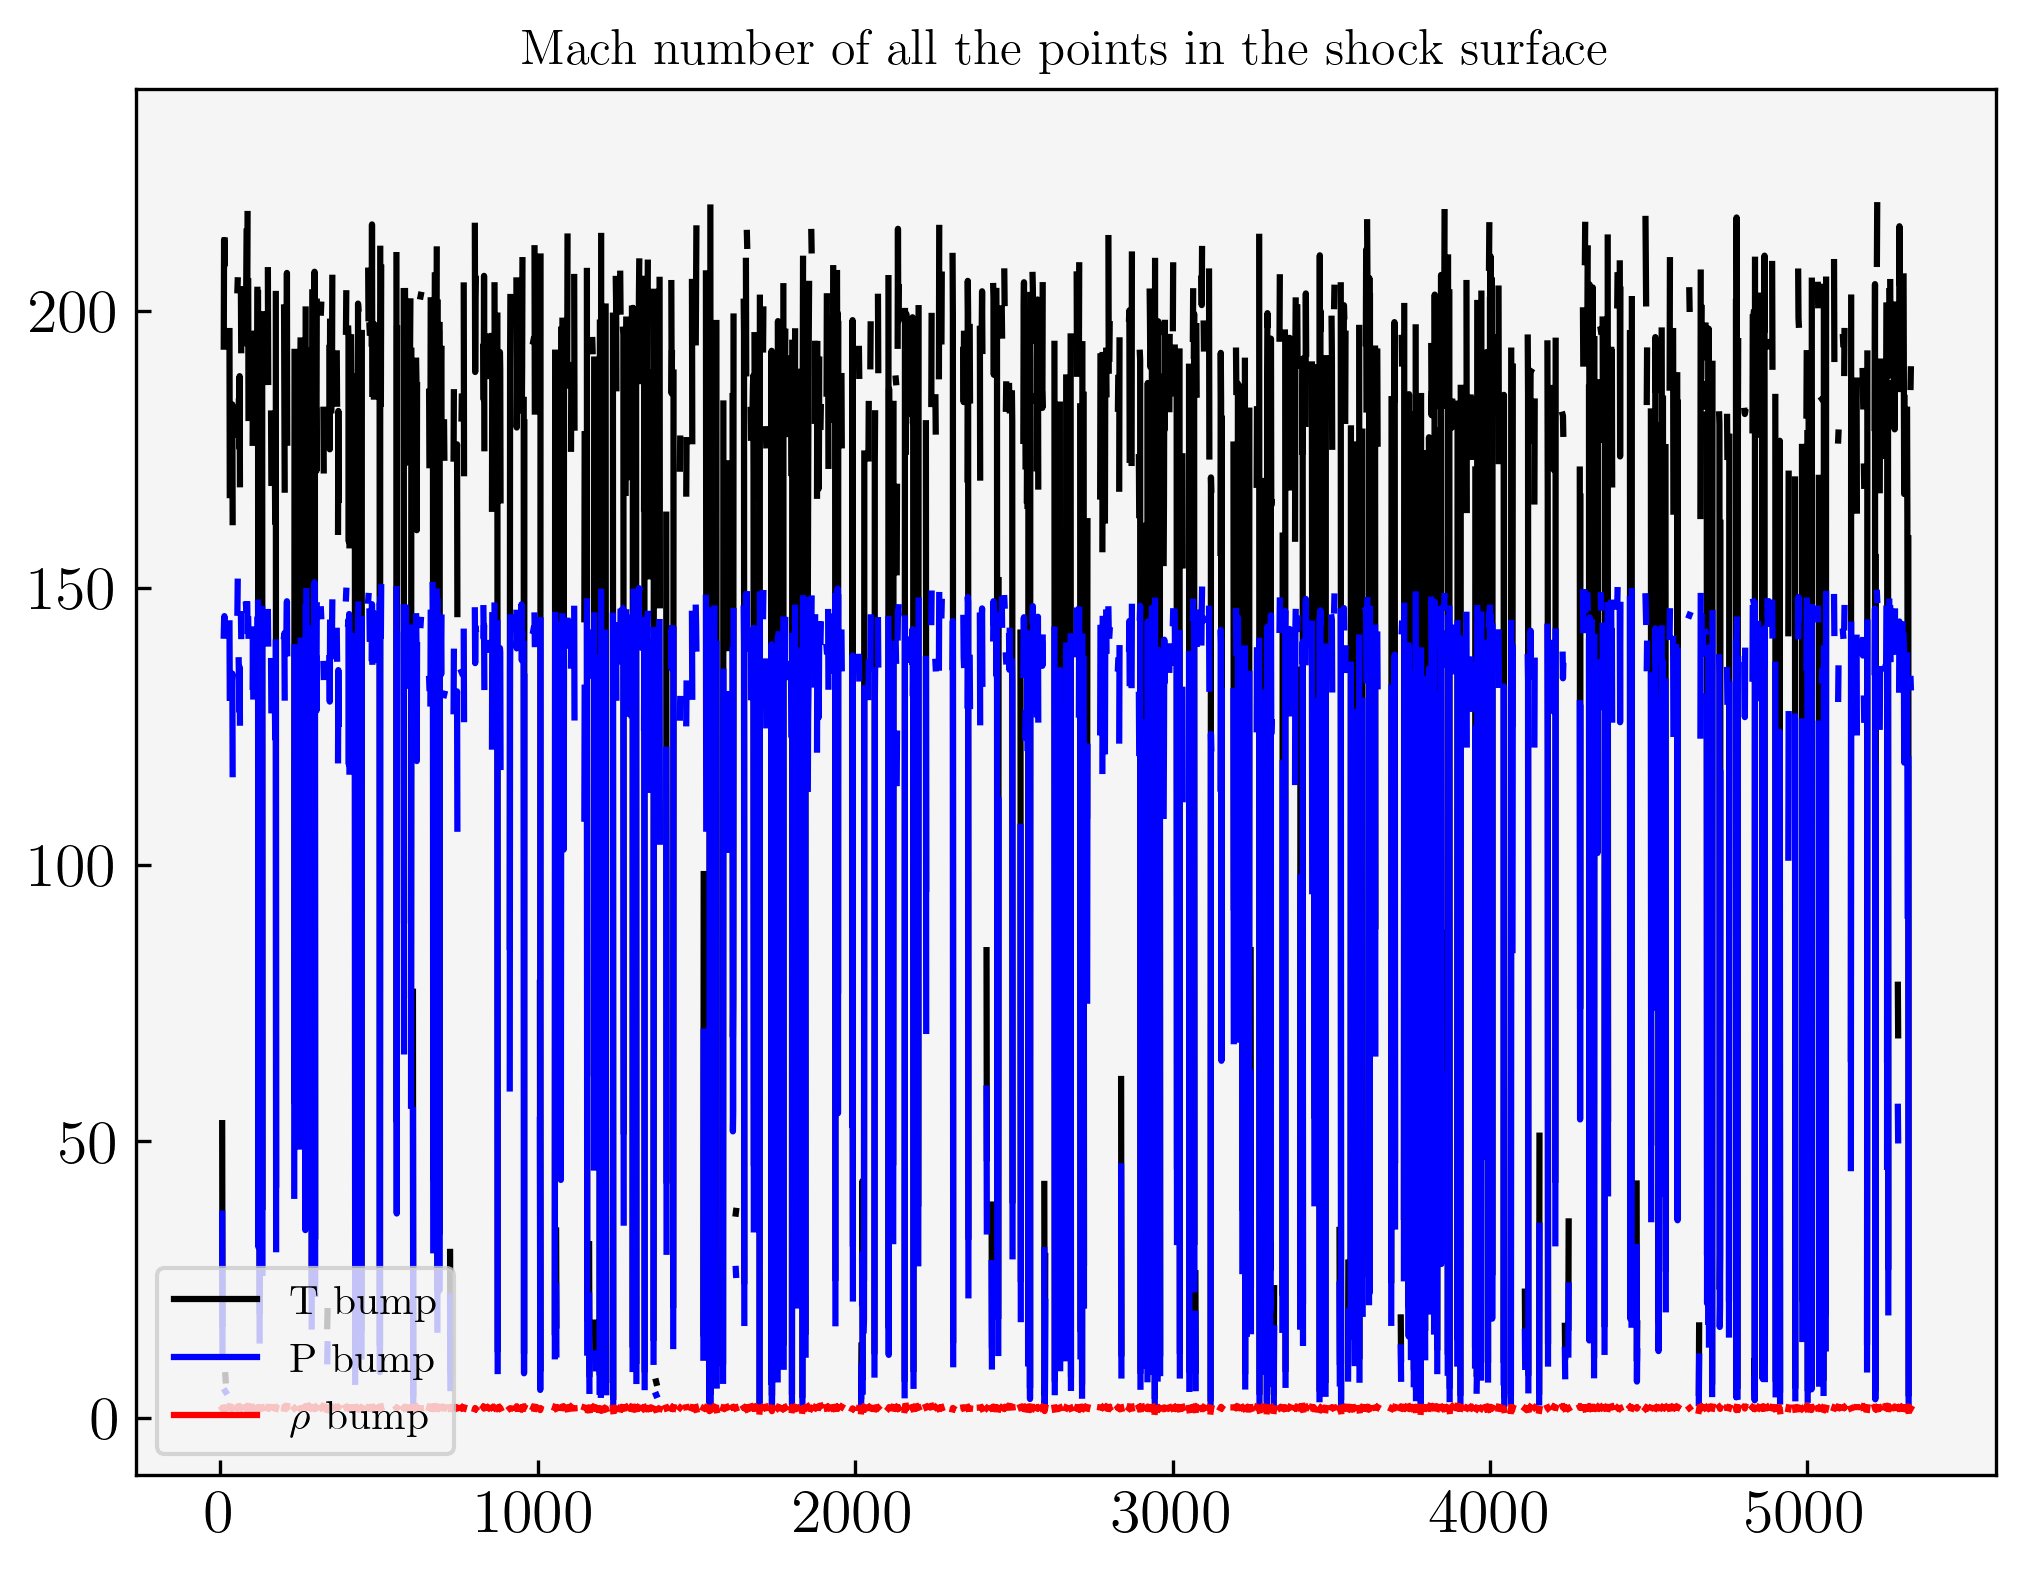

In [19]:
plt.plot(surface_Tmach, c = 'k', label = 'T bump')
plt.plot(surface_Pmach, c = 'b', label = 'P bump')
plt.plot(surface_Denmach, c = 'r',  label = r'$\rho$ bump')
plt.title(f'Mach number of all the points in the shock surface')
plt.legend(loc = 'lower left')
if save:
    plt.savefig(f'Figs/{snap}/mach{snap}.png')

Compare with old data

In [20]:
# oldadata = np.loadtxt(f'data/{snap}/shocksurface_100MYgrad.txt')
# machTold = oldadata[1]
# machPold = oldadata[2]
# machDenold = oldadata[3]

In [21]:
# plt.figure()
# plt.plot(surface_Tmach, c = 'k', label = 'T bump')
# plt.plot(surface_Pmach, c = 'b',   label = 'P bump')
# plt.plot(surface_Denmach, c = 'r',  label = r'$\rho$ bump')

# plt.plot(machTold, c = 'silver', linestyle = '--')
# plt.plot(machPold, c = 'skyblue',  linestyle = '--')
# plt.plot(machDenold, c = 'orange', linestyle = '--')

# plt.title(f'Mach number of all the points in the shock surface')
# plt.legend(loc = 'lower left')
# if save:
#     plt.savefig(f'Figs/{snap}/compareM{snap}.png')

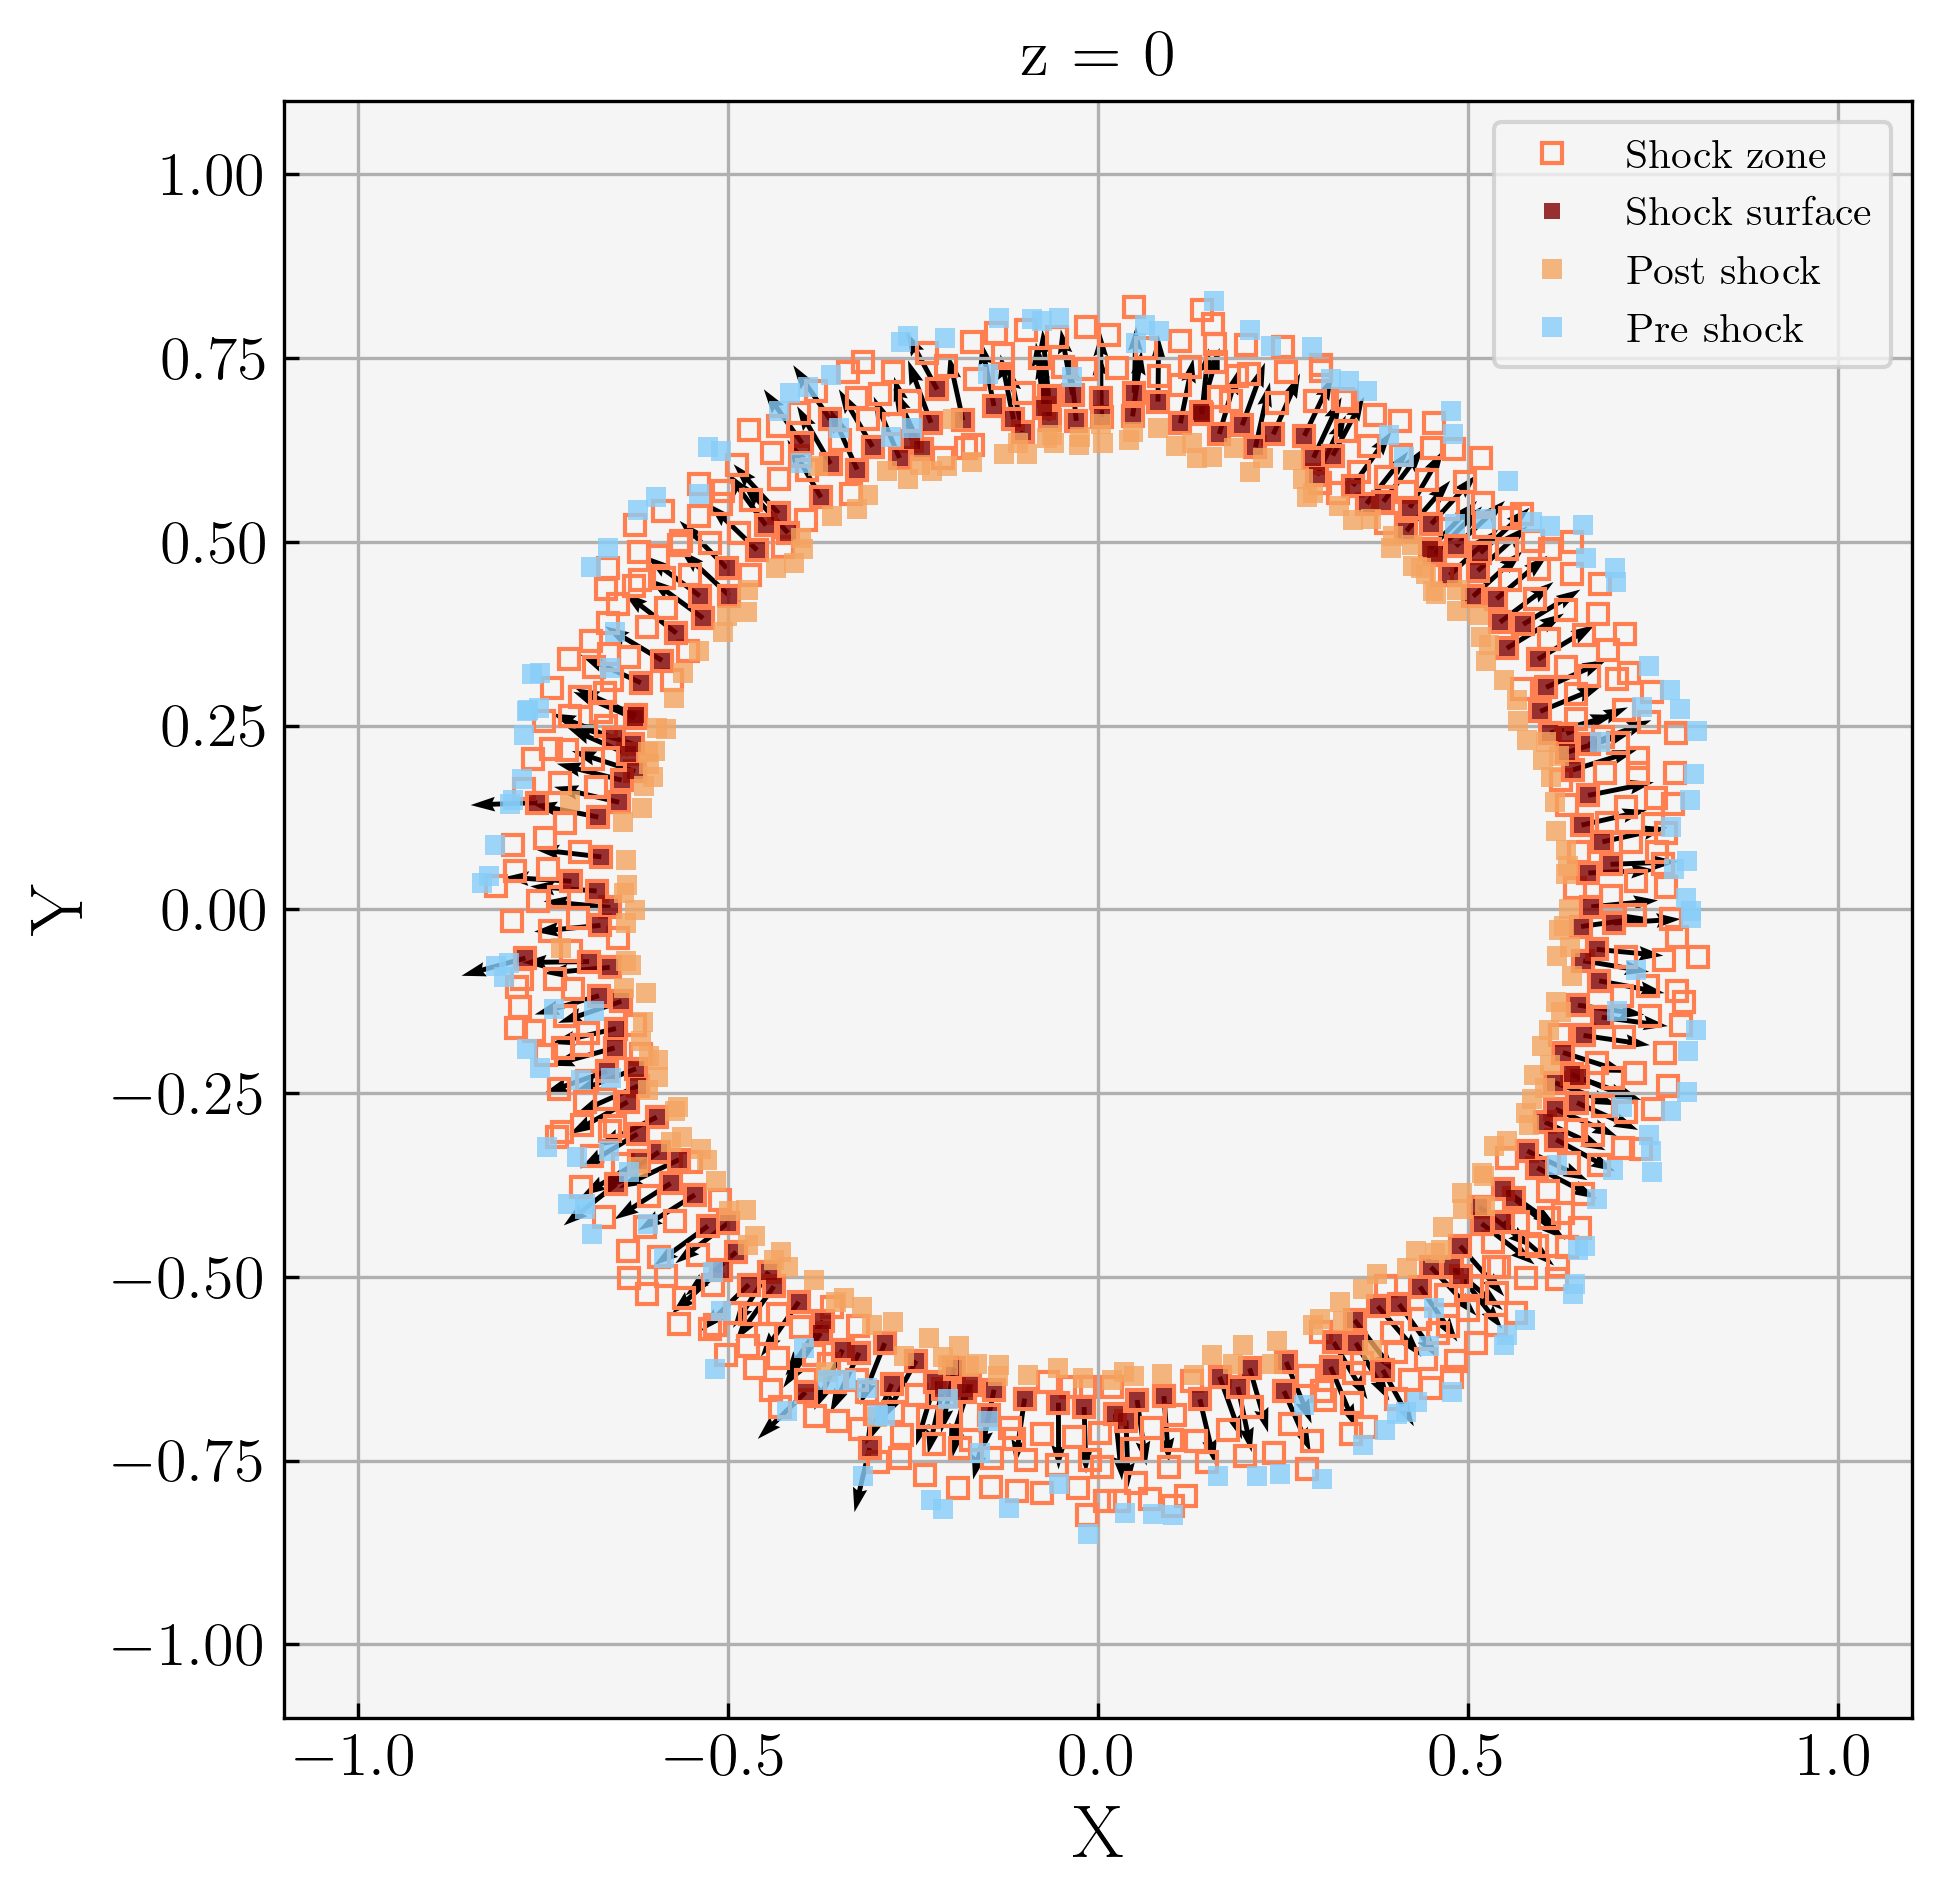

In [22]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (7,7))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
    ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 4, markeredgecolor='none',  alpha = 0.8, label = 'Shock surface')

    ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
    ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')
    ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', width = 3e-3)#, scale = 20)

    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.legend()
    ax.set_title(f'z = {z_chosen}', fontsize = 16)
    plt.grid()
    if save == True:
        plt.savefig(f'Figs/{snap}/5shocksurface_z{z_chosen}_{snap}.png')


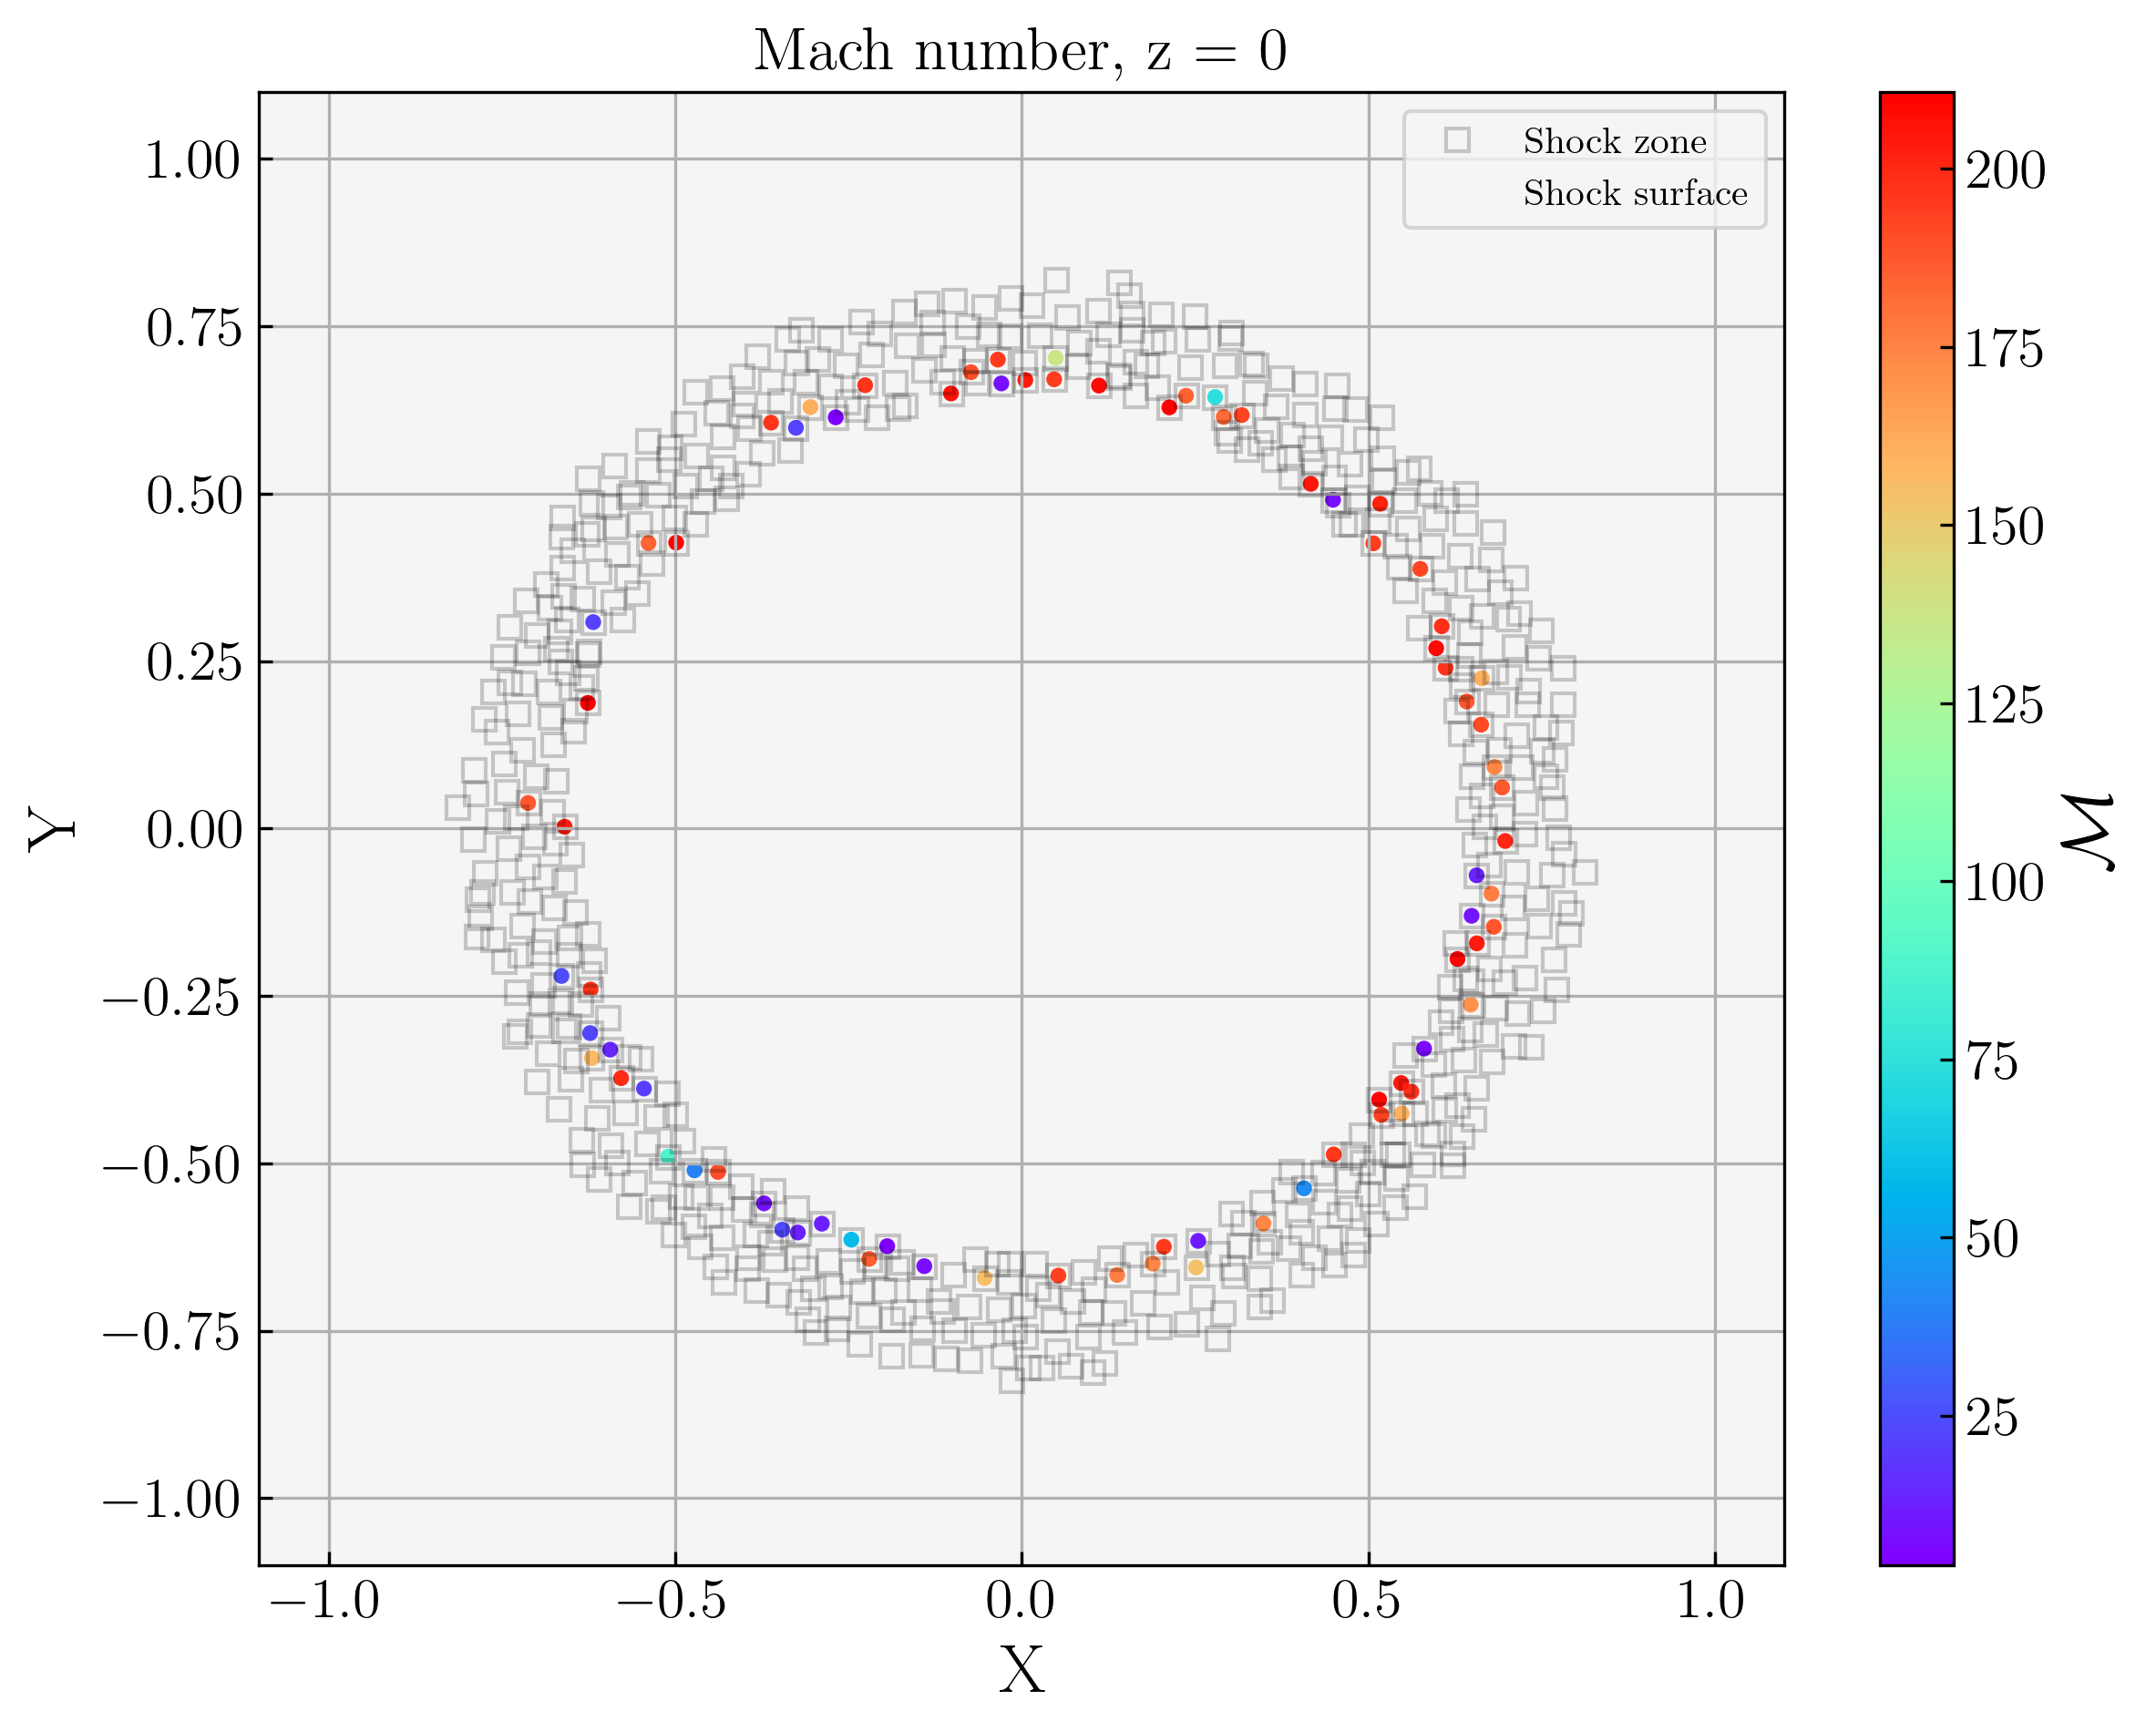

In [23]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (9,7))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.2, label = 'Shock zone')
    img = ax.scatter(surface_cross_x, surface_cross_y, c = surface_Tmach[np.abs(surface_z-z_chosen)<epsilon_surf], s=10,  cmap = 'rainbow', label = 'Shock surface')#, vmin = 110, vmax = 160)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.set_title(f'Mach number, z = {z_chosen}', fontsize = 16)
    ax.legend()
else: 
    Mbh = 10**m 
    Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1
    apocenter = 2 * Rt * Mbh**(1/3)
    fig, ax = plt.subplots(1,1, figsize = (14,7))
    img = ax.scatter(surface_x/apocenter, surface_y/apocenter, c = surface_Tmach, label = 'Shock surface', cmap = 'rainbow', vmin=1, vmax = 8)
    # plt.ylim(-0.3, 0.2)
    # plt.xlim(-1,0.05)
    plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
    plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
cbar = plt.colorbar(img)
cbar.set_label(r'$\mathcal{M}$', fontsize = 19)
plt.grid()
if save == True:
    if folder == 'sedov':
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_z{z_chosen}_{snap}.png')
    else:
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_{snap}.png')
plt.show()